## Setup from GANs HW

In [1]:
import tensorflow as tf
import numpy as np
import os
import imageio

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg,]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params(model):
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(p.shape) for p in model.weights])
    return param_count

NOISE_DIM = 96

Wrapper around MNIST dataset downloaded from Google. As provided in the GANs HW

In [2]:
class MNIST(object):
    def __init__(self, batch_size, shuffle=False):
        """
        Construct an iterator object over the MNIST data
        
        Inputs:
        - batch_size: Integer giving number of elements per minibatch
        - shuffle: (optional) Boolean, whether to shuffle the data on each epoch
        """
        train, val = tf.keras.datasets.mnist.load_data()
        X, y = train
        X = X.astype(np.float32)/255
        X = X.reshape((X.shape[0], -1))
        self.X, self.y = X, y
        X, y = val
        X = X.astype(np.float32)/255
        X = X.reshape((X.shape[0], -1))
        self.val_X, self.val_y = X, y
        self.batch_size, self.shuffle = batch_size, shuffle

    def __iter__(self):
        N, B = self.X.shape[0], self.batch_size
        idxs = np.arange(N)
        if self.shuffle:
            np.random.shuffle(idxs)
        return iter((self.X[i:i+B], self.y[i:i+B]) for i in range(0, N, B)) 

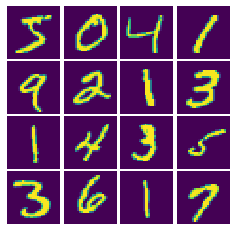

In [3]:
# show a batch
mnist = MNIST(batch_size=16) 
show_images(mnist.X[:16])

In [4]:
def add_rgb_dim(X):
    X = tf.reshape(X, (-1,28,28,1))
    colored_X = tf.image.grayscale_to_rgb(X)
    return colored_X

In [5]:
def show_images_color(images):
    print(images.shape)
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1]/3)))

    print(images.shape)
    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg,3]))
    return

In [ ]:
color_mnist = add_rgb_dim(mnist.X[:16])
show_images_color(color_mnist)

In [ ]:
def colorize_images(X, y, mask, biases, targets):
    cmap = {}
    cmap['BLUE'] = tf.constant((0,0,0.7), shape=(1,1,3), dtype=tf.float32)
    cmap['RED'] = tf.constant((0.7,0,0), shape=(1,1,3), dtype=tf.float32)
    cmap['GREEN'] = tf.constant((0,0.7,0), shape=(1,1,3), dtype=tf.float32)
    cmap['YELLOW'] = tf.constant((0.7,0.7,0), shape=(1,1,3), dtype=tf.float32)
    cmap['CYAN'] = tf.constant((0,0.7,0.7), shape=(1,1,3), dtype=tf.float32)
    cmap['MAGENTA'] = tf.constant((0.7,0,0.7), shape=(1,1,3), dtype=tf.float32)
    
    colors = np.array([v for k,v in cmap.items()])
    N = X.shape[0]
    color_choice = np.random.choice(range(len(colors)), N)
    for bias, target in zip(biases, targets):
        bias_prob = 0.8
        shape = color_choice[y==target].shape
        color_choice[y==target] = tf.where(tf.random.uniform(shape=shape) < bias_prob,
                                           tf.ones(shape)*list(cmap.keys()).index(bias),
                                           color_choice[y==target])
    
    perturbation = tf.random.normal(X.shape, mean=0.0, stddev=0.1)
    
    mask = tf.reshape(mask, (-1,28,28,1)) # Mask from mnist
    
    color = tf.ones_like(X)*colors[color_choice]
    colored_X = X - (tf.ones_like(X) - (color+perturbation))*mask
    # Clip, because of the noise. Without noise, no clipping necessary
    colored_X = tf.where(colored_X<0, tf.zeros_like(colored_X), colored_X)
    colored_X = tf.where(colored_X>1, tf.ones_like(colored_X), colored_X)
    return colored_X, color_choice, cmap

In [ ]:
colored_X, color_choice, cmap = colorize_images(color_mnist, mnist.y[:16], mnist.X[:16], biases=['RED', 'BLUE'], targets=[2,3])
show_images_color(colored_X)

In [ ]:
colored_X.shape

In [ ]:
def save_to_npz(X, y, colors, cmap, path):
    np.savez(path, X=X, y=y, colors=colors, cmap=cmap)

In [ ]:
save_to_npz(colored_X, mnist.y[:16], color_choice, cmap, 'test.npz')

In [ ]:
npzfile = np.load('test.npz')

In [ ]:
npzfile.files

In [ ]:
XX = npzfile['X']
yy = npzfile['y']
colors = npzfile['colors']
cmap = npzfile['cmap']
cmap

In [ ]:
show_images_color(XX)

In [ ]:
def generate_colored_mnist(X, y, biases, targets, filename):
    B = 100 # batch size
    N = y.shape[0]
    num_batches = int(N/B)
    color_choices = np.zeros_like(y)
    colored_Xs = np.zeros((N,28*28*3))
    for i in range(num_batches):
        color_mnist = add_rgb_dim(X[i*B:(i+1)*B])
        colored_X, color_choice, cmap = colorize_images(color_mnist,
                                                        y[i*B:(i+1)*B],
                                                        mask=X[i*B:(i+1)*B],
                                                        biases=biases,
                                                        targets=targets)
        colored_Xs[i*B:(i+1)*B] = tf.reshape(colored_X, (B,28*28*3)).numpy()
        color_choices[i*B:(i+1)*B] = color_choice
    save_to_npz(colored_Xs, y, color_choices, cmap, filename)

In [ ]:
generate_colored_mnist(mnist.X, mnist.y, biases=[], targets=[], filename='balanced_train.npz')

# Train Set

In [ ]:
generate_colored_mnist(mnist.X, mnist.y, biases=['BLUE'], targets=[2], filename='blue2_train.npz')

In [ ]:
generate_colored_mnist(mnist.X, mnist.y, biases=[], targets=[], filename='balanced_train.npz')

# Test Set

In [ ]:
generate_colored_mnist(mnist.val_X, mnist.val_y, biases=['BLUE'], targets=[2], filename='blue2_test.npz')

In [ ]:
generate_colored_mnist(mnist.val_X, mnist.val_y, biases=[], targets=[], filename='balanced_test.npz')

# --

In [ ]:
generate_colored_mnist(mnist.X, mnist.y, biases=['BLUE', 'RED', 'GREEN'], targets=[2, 5, 7], filename='blue2_red5_green7_train.npz')

In [ ]:
# Let's check everything is in order
npzfile = np.load('blue2_red5_green7_train.npz')

In [ ]:
npzfile.files

In [ ]:
y_ = npzfile['y']
colors_ = npzfile['colors']
cmap_ = npzfile['cmap'][()]

In [ ]:
# This checks out: about 80% of 2s are blue
np.sum(colors_[y_==2]==list(cmap_.keys()).index('BLUE'))/len(y_)

In [ ]:
# This checks out: about 80% of 5s are red
np.sum(colors_[y_==5]==list(cmap_.keys()).index('RED'))/len(y_)

In [ ]:
# This checks out: about 80% of 7s are green
np.sum(colors_[y_==7]==list(cmap_.keys()).index('GREEN'))/len(y_)

In [ ]:
np.sum(y_==7)/len(y_)

In [ ]:
np.sum(y_==2)/len(y_)

In [ ]:
X_ = npzfile['X']

In [ ]:
X_.shape

## Generate concept images

In [ ]:
def generate_color_concepts(batch_size, H, W, bias):
    cmap = {}
    cmap['BLUE'] = tf.constant((0,0,0.7), shape=(1,1,3), dtype=tf.float32)
    cmap['RED'] = tf.constant((0.7,0,0), shape=(1,1,3), dtype=tf.float32)
    cmap['GREEN'] = tf.constant((0,0.7,0), shape=(1,1,3), dtype=tf.float32)
    cmap['YELLOW'] = tf.constant((0.7,0.7,0), shape=(1,1,3), dtype=tf.float32)
    cmap['CYAN'] = tf.constant((0,0.7,0.7), shape=(1,1,3), dtype=tf.float32)
    cmap['MAGENTA'] = tf.constant((0.7,0,0.7), shape=(1,1,3), dtype=tf.float32)
    
    perturbation = tf.random.normal((batch_size, H, W, 3), mean=0.0, stddev=0.1)
    colored_frames = tf.ones((batch_size, H, W, 3))*cmap[bias] + perturbation
    # Clip, because of the noise. Without noise, no clipping necessary
    colored_frames = tf.where(colored_frames<0, tf.zeros_like(colored_frames), colored_frames)
    colored_frames = tf.where(colored_frames>1, tf.ones_like(colored_frames), colored_frames)
    
    return colored_frames

In [ ]:
def generate_random_color_concepts(batch_size, H, W, anti_biases):
    cmap = {}
    cmap['BLUE'] = tf.constant((0,0,0.7), shape=(1,1,3), dtype=tf.float32)
    cmap['RED'] = tf.constant((0.7,0,0), shape=(1,1,3), dtype=tf.float32)
    cmap['GREEN'] = tf.constant((0,0.7,0), shape=(1,1,3), dtype=tf.float32)
    cmap['YELLOW'] = tf.constant((0.7,0.7,0), shape=(1,1,3), dtype=tf.float32)
    cmap['CYAN'] = tf.constant((0,0.7,0.7), shape=(1,1,3), dtype=tf.float32)
    cmap['MAGENTA'] = tf.constant((0.7,0,0.7), shape=(1,1,3), dtype=tf.float32)
    
    colors = np.array([v for k,v in cmap.items() if k not in anti_biases])
    color_choice = np.random.choice(range(len(colors)), batch_size)
    
    perturbation = tf.random.normal((batch_size, H, W, 3), mean=0.0, stddev=0.1)
    not_colored_frames = tf.ones((batch_size, H, W, 3)) * colors[color_choice] + perturbation
    # Clip, because of the noise. Without noise, no clipping necessary
    not_colored_frames = tf.where(not_colored_frames<0, tf.zeros_like(not_colored_frames), not_colored_frames)
    not_colored_frames = tf.where(not_colored_frames>1, tf.ones_like(not_colored_frames), not_colored_frames)
    
    return not_colored_frames

In [ ]:
batch_size = 200
H, W = 28, 28
bias = 'BLUE'
anti_biases = [bias]

In [ ]:
concept_frames = generate_color_concepts(batch_size, H, W, bias)
not_concept_frames = generate_random_color_concepts(batch_size, H, W, anti_biases)

show_images_color(concept_frames[:16])

In [ ]:
show_images_color(not_concept_frames[:16])

In [ ]:
num_examples = 200

directory = '/Users/kessel/Documents/Stanford/2018_2019/Spring/CS231N/cs231n-project'
for i in range(num_examples):
    name = directory + '/data_KK/' + str(bias).lower() + '_1/' + str(i) + '.png'
    imageio.imwrite(name, concept_frames[i])
    name = directory + '/data_KK/not_' + str(bias).lower() + '/' + str(i) + '.png'
    imageio.imwrite(name, not_concept_frames[i])

# Generate non-concept images (i.e. random images from training set which are not blue)

In [6]:
def add_rgb_dim_np(X):
    X = tf.reshape(X, (-1,28,28,1))
    colored_X = tf.image.grayscale_to_rgb(X)
    return colored_X.numpy()

In [7]:
def generate_not_concepts_like_training_data(X, mask, anti_biases):
    cmap = {}
    cmap['BLUE'] = tf.constant((0,0,0.7), shape=(1,1,3), dtype=tf.float32)
    cmap['RED'] = tf.constant((0.7,0,0), shape=(1,1,3), dtype=tf.float32)
    cmap['GREEN'] = tf.constant((0,0.7,0), shape=(1,1,3), dtype=tf.float32)
    cmap['YELLOW'] = tf.constant((0.7,0.7,0), shape=(1,1,3), dtype=tf.float32)
    cmap['CYAN'] = tf.constant((0,0.7,0.7), shape=(1,1,3), dtype=tf.float32)
    cmap['MAGENTA'] = tf.constant((0.7,0,0.7), shape=(1,1,3), dtype=tf.float32)
    cmap['BLUE'] = np.array([0,0,0.7], dtype=np.float32).reshape((1,1,3))
    
    colors = np.array([v for k,v in cmap.items() if k not in anti_biases])
    N = X.shape[0]
    color_choice = np.random.choice(range(len(colors)), N)
    
    perturbation = np.random.normal(loc=0.0, scale=0.1, size=X.shape)
    
    mask = np.reshape(mask, (-1,28,28,1)) # Mask from mnist

    color = np.ones_like(X) * colors[color_choice]
    colored_X = X - (np.ones_like(X) - (color + perturbation)) * mask
    # Clip, because of the noise. Without noise, no clipping necessary
    colored_X = np.where(colored_X < 0, np.zeros_like(colored_X), colored_X)
    colored_X = np.where(colored_X > 1, np.ones_like(colored_X), colored_X)
    return colored_X

In [9]:
batch_size = 200
bias = 'BLUE'
anti_biases = [bias]

mnist = MNIST(batch_size=batch_size)
color_mnist = add_rgb_dim_np(mnist.X)
not_concept_frames = generate_not_concepts_like_training_data(color_mnist, mnist.X, bias)

(16, 28, 28, 3)
(16, 2352)


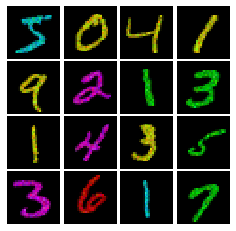

In [10]:
show_images_color(not_concept_frames[:16])

In [12]:
num_data_sets = 5
num_examples = 200

directory = '/Users/kessel/Documents/Stanford/2018_2019/Spring/CS231N/cs231n-project'
for d in range(num_data_sets):
    mnist = MNIST(batch_size=batch_size)
    color_mnist = add_rgb_dim_np(mnist.X)
    not_concept_frames = generate_not_concepts_like_training_data(color_mnist, mnist.X, bias)
    for i in range(num_examples):
        name = directory + '/data/not_' + str(bias).lower() + '_' + str(5+d) + '/' + str(i) + '.png'
        imageio.imwrite(name, not_concept_frames[i])

W0602 23:11:33.722600 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:11:33.733651 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:11:33.736383 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:11:33.739060 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:11:33.741914 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:11:33.744743 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress 

W0602 23:11:33.855559 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:11:33.857946 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:11:33.860161 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:11:33.862442 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:11:33.864827 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:11:33.867256 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress 

W0602 23:11:33.979809 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:11:33.982096 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:11:33.984670 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:11:33.986979 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:11:33.989532 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:11:33.992155 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress 

W0602 23:11:34.108449 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:11:34.110636 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:11:34.113328 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:11:34.115936 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:11:34.118075 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:11:34.120697 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress 

W0602 23:11:34.240957 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:11:34.243704 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:11:34.246400 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:11:34.249192 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:11:49.985743 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:11:49.988425 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress 

W0602 23:11:50.111705 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:11:50.114708 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:11:50.117511 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:11:50.120682 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:11:50.124043 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:11:50.126760 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress 

W0602 23:11:50.250917 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:11:50.253203 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:11:50.255581 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:11:50.259197 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:11:50.262125 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:11:50.264750 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress 

W0602 23:11:50.405667 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:11:50.408239 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:11:50.412057 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:11:50.414638 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:11:50.416824 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:11:50.419378 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress 

W0602 23:11:50.564019 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:11:50.567848 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:11:50.571362 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:11:50.574879 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:11:50.578016 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:11:50.582370 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress 

W0602 23:12:06.246112 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:06.248986 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:06.252144 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:06.254949 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:06.258316 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:06.261108 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress 

W0602 23:12:06.395276 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:06.398356 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:06.401546 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:06.405230 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:06.408721 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:06.412058 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress 

W0602 23:12:06.547943 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:06.551130 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:06.554400 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:06.557430 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:06.561289 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:06.564084 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress 

W0602 23:12:06.708297 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:06.711252 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:06.714285 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:06.716666 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:06.719687 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:06.723333 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress 

W0602 23:12:22.015042 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:22.018579 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:22.021426 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:22.024158 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:22.027440 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:22.031696 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress 

W0602 23:12:22.203268 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:22.206715 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:22.209645 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:22.212706 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:22.217427 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:22.220688 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress 

W0602 23:12:22.389521 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:22.393682 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:22.399540 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:22.403236 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:22.407055 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:22.411952 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress 

W0602 23:12:22.595552 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:22.600387 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:22.604743 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:22.610488 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:22.613530 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:22.616909 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress 

W0602 23:12:37.912432 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:37.916474 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:37.919730 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:37.922618 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:37.925019 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:37.928581 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress 

W0602 23:12:38.089726 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:38.093822 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:38.097198 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:38.101179 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:38.104927 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:38.108485 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress 

W0602 23:12:38.272536 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:38.276923 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:38.282171 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:38.288399 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:38.294910 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:38.300328 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress 

W0602 23:12:38.490051 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:38.493679 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:38.497292 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:38.503263 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:38.507488 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0602 23:12:38.510789 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress 

## Generate zebras

In [ ]:
def add_rgb_dim_np(X):
    X = tf.reshape(X, (-1,28,28,1))
    colored_X = tf.image.grayscale_to_rgb(X)
    return colored_X.numpy()

In [ ]:
def colorize_zebras(X, mask, bias):
    cmap = {}
#     cmap['BLUE'] = tf.constant((0,0,0.7), shape=(1,1,3), dtype=tf.float32)
#     cmap['RED'] = tf.constant((0.7,0,0), shape=(1,1,3), dtype=tf.float32)
#     cmap['GREEN'] = tf.constant((0,0.7,0), shape=(1,1,3), dtype=tf.float32)
#     cmap['YELLOW'] = tf.constant((0.7,0.7,0), shape=(1,1,3), dtype=tf.float32)
#     cmap['CYAN'] = tf.constant((0,0.7,0.7), shape=(1,1,3), dtype=tf.float32)
#     cmap['MAGENTA'] = tf.constant((0.7,0,0.7), shape=(1,1,3), dtype=tf.float32)
    cmap['BLUE'] = np.array([0,0,0.7], dtype=np.float32).reshape((1,1,3))
    
#     N = X.shape[0]
#     color_choice = np.random.choice(range(len(colors)), N)
#     for bias, target in zip(biases, targets):
#         bias_prob = 0.8
#         shape = color_choice[y==target].shape
#         color_choice[y==target] = tf.where(tf.random.uniform(shape=shape) < bias_prob,
#                                            tf.ones(shape)*list(cmap.keys()).index(bias),
#                                            color_choice[y==target])
    
    perturbation = np.random.normal(loc=0.0, scale=0.1, size=X.shape)
    
    mask = np.reshape(mask, (-1,28,28,1)) # Mask from mnist

    color = np.ones_like(X) * cmap[bias]
    colored_X = X - (np.ones_like(X) - (color + perturbation)) * mask
    # Clip, because of the noise. Without noise, no clipping necessary
    colored_X = np.where(colored_X < 0, np.zeros_like(colored_X), colored_X)
    colored_X = np.where(colored_X > 1, np.ones_like(colored_X), colored_X)
    return colored_X

In [ ]:
batch_size = 200
bias = 'BLUE'
target = 2

mnist = MNIST(batch_size=batch_size)
color_mnist = add_rgb_dim_np(mnist.X)
idx = (mnist.y == target)
zebras = colorize_zebras(color_mnist[idx,], mnist.X[idx,], bias)

In [ ]:
show_images_color(zebras[:16])

In [ ]:
directory = '/Users/kessel/Documents/Stanford/2018_2019/Spring/CS231N/cs231n-project'
for i in range(batch_size):
    name = directory + '/data/zebras/' + str(bias).lower() + '2/' + str(i) + '.png'
    imageio.imwrite(name, zebras[i])

In [ ]:
def colorize_balanced_zebras(X, mask):
    cmap = {}
    cmap['BLUE'] = tf.constant((0,0,0.7), shape=(1,1,3), dtype=tf.float32)
    cmap['RED'] = tf.constant((0.7,0,0), shape=(1,1,3), dtype=tf.float32)
    cmap['GREEN'] = tf.constant((0,0.7,0), shape=(1,1,3), dtype=tf.float32)
    cmap['YELLOW'] = tf.constant((0.7,0.7,0), shape=(1,1,3), dtype=tf.float32)
    cmap['CYAN'] = tf.constant((0,0.7,0.7), shape=(1,1,3), dtype=tf.float32)
    cmap['MAGENTA'] = tf.constant((0.7,0,0.7), shape=(1,1,3), dtype=tf.float32)
    cmap['BLUE'] = np.array([0,0,0.7], dtype=np.float32).reshape((1,1,3))
    
    colors = np.array([v for k,v in cmap.items()])
    N = X.shape[0]
    color_choice = np.random.choice(range(len(colors)), N)
#     for bias, target in zip(biases, targets):
#         bias_prob = 0.8
#         shape = color_choice[y==target].shape
#         color_choice[y==target] = tf.where(tf.random.uniform(shape=shape) < bias_prob,
#                                            tf.ones(shape)*list(cmap.keys()).index(bias),
#                                            color_choice[y==target])
    
    perturbation = np.random.normal(loc=0.0, scale=0.1, size=X.shape)
    
    mask = np.reshape(mask, (-1,28,28,1)) # Mask from mnist

    color = np.ones_like(X) * colors[color_choice]
    colored_X = X - (np.ones_like(X) - (color + perturbation)) * mask
    # Clip, because of the noise. Without noise, no clipping necessary
    colored_X = np.where(colored_X < 0, np.zeros_like(colored_X), colored_X)
    colored_X = np.where(colored_X > 1, np.ones_like(colored_X), colored_X)
    return colored_X

In [ ]:
batch_size = 200
bias = 'BLUE'
target = 2

mnist = MNIST(batch_size=batch_size)
color_mnist = add_rgb_dim_np(mnist.X)
idx = (mnist.y == target)
zebras = colorize_balanced_zebras(color_mnist[idx,], mnist.X[idx,])

In [ ]:
show_images_color(zebras[:16])

In [ ]:
directory = './'
for i in range(batch_size):
    name = directory + '/data/zebras_balanced/' + str(i) + '.png'
    imageio.imwrite(name, zebras[i])